### Getting Setup

In [50]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchinfo import summary
import matplotlib.pyplot as plt
from timeit import default_timer as timer

import sys
sys.path.insert(1, '../05/')
from going_modular import data_setup, engine
import pandas as pd
from helper_functions import plot_loss_curves
from PIL import Image
import random
from pathlib import Path

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

### Get data

In [4]:
train_dir = 'data/pizza_steak_sushi/train'
test_dir = 'data/pizza_steak_sushi/test'

### Create Datasets and DataLoaders

#### Create a transform for torchvision.models (manual creation)

In [5]:
manual_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
train_loader, test_loader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transform,
    batch_size = 32
)

#### Creating a transform for torchvision.models (auto creation)

In [10]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [12]:
# Get transforms associated with the pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [13]:
train_loader, test_loader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = auto_transforms,
    batch_size = 32
)

train_loader, test_loader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x15a612a50>,
 ['pizza', 'steak', 'sushi'])

### Getting a pretrained model

#### Setting up a ptretrained model

In [35]:
model = torchvision.models.efficientnet_b0(weights=weights, progress=True).to(device)

#### Getting summary with torchinfo.summary()

In [36]:
summary(
    model=model,
    input_size=(32, 3, 224, 224),
    col_names=['input_size', 'output_size', 'num_params','trainable'],
    col_width=20,
    row_settings=['var_names']
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

#### Freezing base model and change output layer to suit our needs

In [37]:
# Freeze all base layers in features section
for param in model.features.parameters():
    param.requires_grad = False # pytorch doesnt track gradient updates and now they wont
                                # be changed by optimizer during training

In [38]:
# Set manual seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=output_shape, bias=True)
).to(device)

In [39]:
# # Do a summary *after* freezing the features and changing the output classifier layer
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

### Train model

In [40]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [42]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
start_time = timer()

results = engine.train(
    model = model,
    train_loader = train_loader,
    test_loader = test_loader,
    optimizer = optimizer,
    loss_fn = loss_fn,
    epochs = 5,
    device = device
)
end_time = timer()
print(f'[INFO] Total training time: {end_time - start_time:.3f} seconds.')


  0%|          | 0/5 [00:00<?, ?it/s]/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_p

Epoch: 1 | Train loss: 1.0883 | Train acc: 0.4180 | Test loss: 0.8914 | Test acc: 0.6818


/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/hom

Epoch: 2 | Train loss: 0.9162 | Train acc: 0.6289 | Test loss: 0.8027 | Test acc: 0.7443


/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/hom

Epoch: 3 | Train loss: 0.8162 | Train acc: 0.7031 | Test loss: 0.6787 | Test acc: 0.9072


/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/hom

Epoch: 4 | Train loss: 0.7460 | Train acc: 0.7305 | Test loss: 0.6744 | Test acc: 0.8040


/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/hom

Epoch: 5 | Train loss: 0.6209 | Train acc: 0.7695 | Test loss: 0.6263 | Test acc: 0.8561
[INFO] Total training time: 404.479 seconds.


In [45]:
model_results_df = pd.DataFrame(results)
model_results_df

,train_loss,train_acc,test_loss,test_acc
0,1.088293,0.417969,0.891449,0.681818
1,0.916157,0.628906,0.802718,0.744318
2,0.816206,0.703125,0.678671,0.907197
3,0.746013,0.730469,0.674439,0.803977
4,0.620860,0.769531,0.626296,0.856061


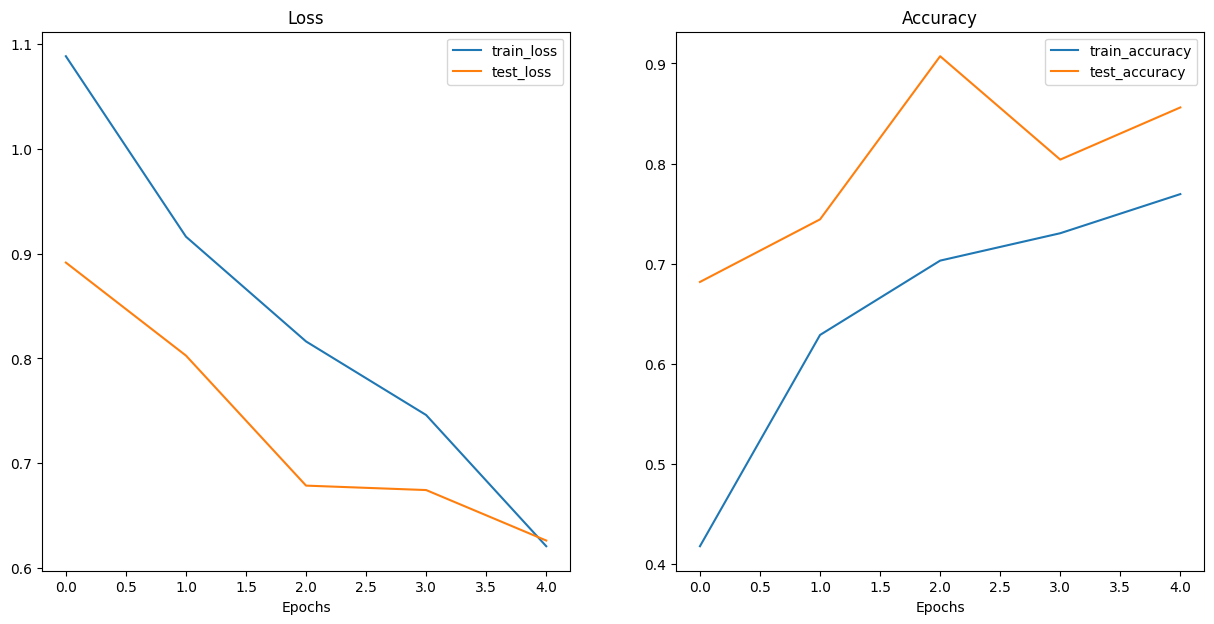

In [46]:
plot_loss_curves(results)

### Make predictions on images from test set

In [48]:
def pred_and_plot_image(model, img_path, class_names, img_size, transform, device):
    img = Image.open(img_path)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(size=(img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    model.to(device)

    model.eval()
    with torch.inference_mode():
        transformed_img = image_transform(img).unsqueeze(dim=0)
        target_img_pred = torch.softmax(model(transformed_img.to(device)), dim=1).argmax(dim=1)
    plt.figure()
    plt.imshow(img)
    plt.title(f'Pred: {class_names[target_img_pred]}')
    plt.axis(False)

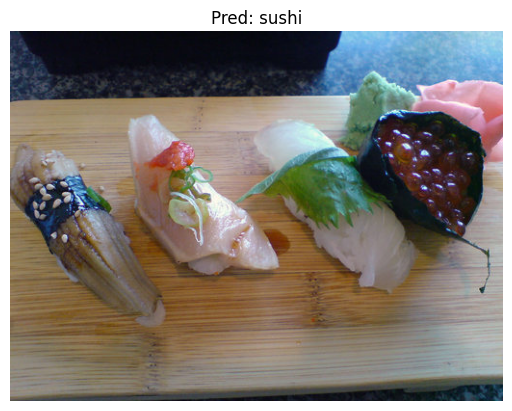

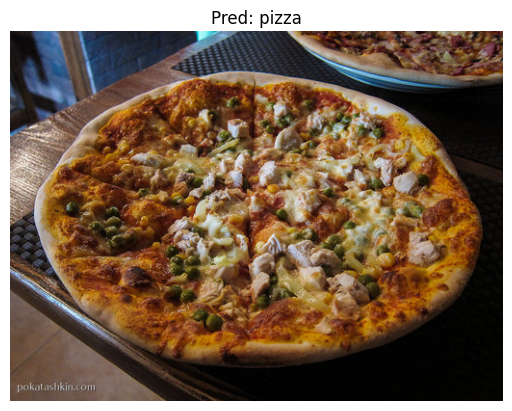

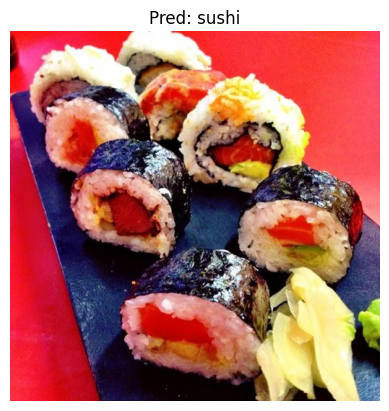

In [51]:
num_imgs = 3
test_img_path_list = list(Path(test_dir).glob('*/*.jpg'))
test_img_path_sample = random.sample(population=test_img_path_list, k=num_imgs)

for img_path in test_img_path_sample:
    pred_and_plot_image(model=model, img_path=img_path, class_names=class_names, img_size=(224, 224), transform=None, device=device)

#### Making prediction on custom image

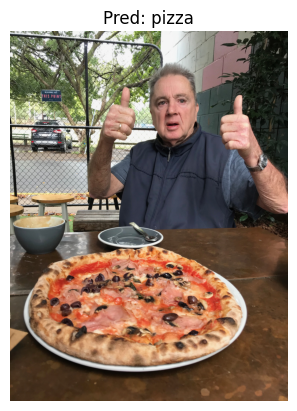

In [52]:
pred_and_plot_image(model=model, img_path='data/04-pizza-dad.jpeg', class_names=class_names, img_size=(224, 224), transform=None, device=device)